類別對應: {'bad': 0, 'good': 1}


Epoch 1/40: 100%|██████████| 28/28 [00:09<00:00,  3.09it/s, acc=59.4, loss=0.66] 


🧠 Epoch 1: Train Loss: 21.0498, Accuracy: 59.43%
📉 驗證準確率: 63.64%


Epoch 2/40: 100%|██████████| 28/28 [00:07<00:00,  3.69it/s, acc=66.5, loss=0.677]


🧠 Epoch 2: Train Loss: 17.8144, Accuracy: 66.50%
📉 驗證準確率: 63.52%
⚠️ 早停計數: 1/6


Epoch 3/40: 100%|██████████| 28/28 [00:07<00:00,  3.56it/s, acc=66.1, loss=0.561]


🧠 Epoch 3: Train Loss: 17.5751, Accuracy: 66.13%
📉 驗證準確率: 63.64%
✅ 驗證準確度提升: 63.64 → 63.64，重置計數


Epoch 4/40: 100%|██████████| 28/28 [00:07<00:00,  3.59it/s, acc=66.9, loss=0.689]


🧠 Epoch 4: Train Loss: 17.5136, Accuracy: 66.89%
📉 驗證準確率: 63.30%
⚠️ 早停計數: 1/6


Epoch 5/40: 100%|██████████| 28/28 [00:07<00:00,  3.64it/s, acc=67.6, loss=0.624]


🧠 Epoch 5: Train Loss: 16.9812, Accuracy: 67.62%
📉 驗證準確率: 63.86%
✅ 驗證準確度提升: 63.64 → 63.86，重置計數


Epoch 6/40: 100%|██████████| 28/28 [00:07<00:00,  3.54it/s, acc=69.5, loss=0.651]


🧠 Epoch 6: Train Loss: 16.6673, Accuracy: 69.53%
📉 驗證準確率: 64.09%
✅ 驗證準確度提升: 63.86 → 64.09，重置計數


Epoch 7/40: 100%|██████████| 28/28 [00:07<00:00,  3.50it/s, acc=70.7, loss=0.578]


🧠 Epoch 7: Train Loss: 15.9322, Accuracy: 70.71%
📉 驗證準確率: 64.65%
✅ 驗證準確度提升: 64.09 → 64.65，重置計數


Epoch 8/40: 100%|██████████| 28/28 [00:07<00:00,  3.63it/s, acc=73.5, loss=0.576]


🧠 Epoch 8: Train Loss: 14.8839, Accuracy: 73.54%
📉 驗證準確率: 64.42%
⚠️ 早停計數: 1/6


Epoch 9/40: 100%|██████████| 28/28 [00:07<00:00,  3.58it/s, acc=75.3, loss=0.479]


🧠 Epoch 9: Train Loss: 13.7175, Accuracy: 75.28%
📉 驗證準確率: 62.85%
⚠️ 早停計數: 2/6


Epoch 10/40: 100%|██████████| 28/28 [00:07<00:00,  3.67it/s, acc=78.8, loss=0.419]


🧠 Epoch 10: Train Loss: 12.3977, Accuracy: 78.82%
📉 驗證準確率: 63.41%
⚠️ 早停計數: 3/6


Epoch 11/40: 100%|██████████| 28/28 [00:07<00:00,  3.71it/s, acc=81.1, loss=0.37] 


🧠 Epoch 11: Train Loss: 11.2964, Accuracy: 81.12%
📉 驗證準確率: 62.18%
⚠️ 早停計數: 4/6


Epoch 12/40: 100%|██████████| 28/28 [00:07<00:00,  3.59it/s, acc=85.8, loss=0.376]


🧠 Epoch 12: Train Loss: 9.1335, Accuracy: 85.77%
📉 驗證準確率: 63.30%
⚠️ 早停計數: 5/6


Epoch 13/40: 100%|██████████| 28/28 [00:07<00:00,  3.56it/s, acc=89, loss=0.295]  


🧠 Epoch 13: Train Loss: 7.3276, Accuracy: 88.97%
📉 驗證準確率: 62.29%
⚠️ 早停計數: 6/6
🛑 早停觸發，訓練終止
📦 模型已儲存


Testing: 100%|██████████| 7/7 [00:00<00:00,  9.53it/s]


✅ 測試準確率: 62.29%


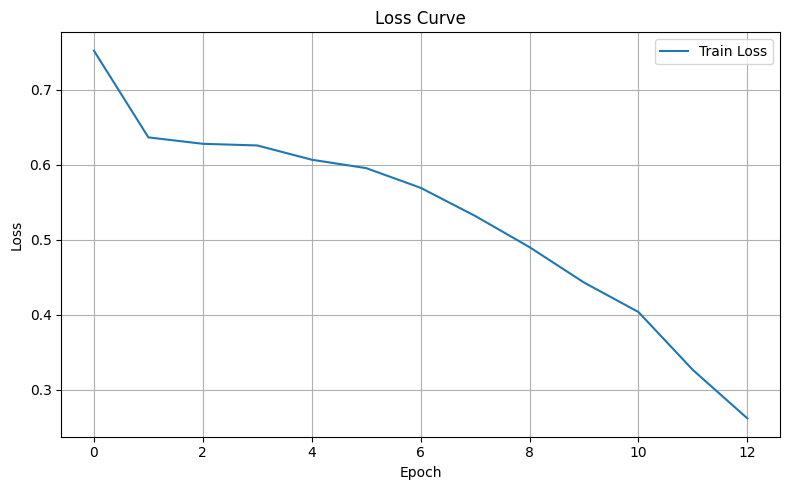

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.models import convnext_tiny
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# EarlyStopping 類別
class EarlyStopping:
    def __init__(self, patience=8, delta=0, verbose=True):
        self.patience = patience
        self.counter = 0
        self.best_acc = None
        self.early_stop = False
        self.delta = delta
        self.best_model_state = None
        self.verbose = verbose

    def __call__(self, acc, model):
        if self.best_acc is None:
            self.best_acc = acc
            self.best_model_state = model.state_dict()
        elif acc < self.best_acc + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"⚠️ 早停計數: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if self.verbose:
                print(f"✅ 驗證準確度提升: {self.best_acc:.2f} → {acc:.2f}，重置計數")
            self.best_acc = acc
            self.best_model_state = model.state_dict()
            self.counter = 0

# 裝置設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 圖像處理
dataset_path = "corp_augmented_data"
batch_size = 128
img_size = 64

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# 資料集
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"類別對應: {dataset.class_to_idx}")

# 模型
model = convnext_tiny(weights=None)
model.classifier[2] = nn.Linear(model.classifier[2].in_features, 2)
model = model.to(device)

# 損失與優化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
early_stopper = EarlyStopping(patience=6)

# 訓練變數
num_epochs = 40
train_losses = []
val_accuracies = []

# 訓練迴圈
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, labels in progress:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
        progress.set_postfix(loss=loss.item(), acc=100 * correct / total)

    train_acc = 100 * correct / total
    train_losses.append(running_loss / len(train_loader))
    print(f"🧠 Epoch {epoch+1}: Train Loss: {running_loss:.4f}, Accuracy: {train_acc:.2f}%")

    # 驗證
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            val_correct += preds.eq(labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total
    val_accuracies.append(val_acc)
    print(f"📉 驗證準確率: {val_acc:.2f}%")

    # 檢查早停
    early_stopper(val_acc, model)
    if early_stopper.early_stop:
        print("🛑 早停觸發，訓練終止")
        break

# 儲存最佳模型
torch.save(early_stopper.best_model_state, "convnext_tiny_coffeebean_best.pth")
print("📦 模型已儲存")

# 測試
model.load_state_dict(early_stopper.best_model_state)
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

print(f"✅ 測試準確率: {100 * correct / total:.2f}%")

# 🔍 繪製 Loss 曲線
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("loss_curve.png")
plt.show()
